<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Regression Analysis | Apprentice Chef dataset </h2>
<h4>Machine Learning</h4><br>
Christian Romero - MsBA 2
Hult International Business School<br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br><br>
<h2>Goal: </h2><br>
Build amachine learning model to predict revenue over the first year of each customer’s life cycle.
<br><br>
<h2>Objectives: </h2><br>
a) Obtain a model with a test score higher than 0.75 and a train gap of less than 0.05<br>
b) Transform and feature engineer features to achieve results
<br><br><br>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

In [225]:
#Importing my libraries, import dataset and add a wider screen option for better visualization

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gender_guesser.detector as gender

import statsmodels.formula.api as smf # regression modeling

from sklearn.model_selection import train_test_split # train/test split
from sklearn.linear_model import LinearRegression
import sklearn.linear_model


from sklearn.neighbors import KNeighborsRegressor 
from sklearn.preprocessing import StandardScaler 

#Import our data

file = "Apprentice_Chef_Dataset.xlsx"

dataset = pd.read_excel(io=file)

In [226]:
#Checking for missing values

for column in dataset:

    if dataset[column].isnull().astype(int).sum() > 0:
        dataset['m_'+column] = dataset[column].isnull().astype(int)
        
        
dataset[['m_FAMILY_NAME']].sum(axis = 0)

m_FAMILY_NAME    47
dtype: int64

In [227]:
#Quick Correlation analysis to create a base model for further model comparison

features = dataset.columns.tolist()

correl = dataset[features].corr(method = 'pearson')

print(f"""{correl.loc[ : , 'REVENUE'].round(decimals = 2).sort_values(ascending = False)}""")

REVENUE                        1.00
AVG_PREP_VID_TIME              0.64
MEDIAN_MEAL_RATING             0.61
TOTAL_MEALS_ORDERED            0.60
TOTAL_PHOTOS_VIEWED            0.47
MASTER_CLASSES_ATTENDED        0.45
LARGEST_ORDER_SIZE             0.44
AVG_TIME_PER_SITE_VISIT        0.14
CONTACTS_W_CUSTOMER_SERVICE    0.10
PRODUCT_CATEGORIES_VIEWED      0.03
MOBILE_NUMBER                  0.03
PC_LOGINS                      0.02
WEEKLY_PLAN                    0.01
TASTES_AND_PREFERENCES         0.01
CANCELLATIONS_BEFORE_NOON      0.01
REFRIGERATED_LOCKER           -0.00
EARLY_DELIVERIES              -0.00
CROSS_SELL_SUCCESS             0.00
m_FAMILY_NAME                 -0.01
LATE_DELIVERIES               -0.01
PACKAGE_LOCKER                -0.01
MOBILE_LOGINS                 -0.02
CANCELLATIONS_AFTER_NOON      -0.04
UNIQUE_MEALS_PURCH            -0.06
AVG_CLICKS_PER_VISIT          -0.55
Name: REVENUE, dtype: float64


In [228]:
# Log Transforming REVENUE to obtain a more normally distributed response (Minimize the effect of positive skewness)

dataset['LOG_REV'] = np.log10(dataset["REVENUE"]) #Create new column with the LOG of Revenue

print(f"""The skewness without transformation is: {dataset['REVENUE'].skew()}

The skewness with Log Transformation is: {dataset['LOG_REV'].skew()}""")

The skewness without transformation is: 1.626573242157379

The skewness with Log Transformation is: 0.18408997725435583


In [229]:
#LOG transformation of 'continuous' variables:

dataset['LOG_AVG_PREP_VID_TIME'] = np.log10(dataset['AVG_PREP_VID_TIME'])

dataset['LOG_TOTAL_MEALS_ORDERED'] = np.log10(dataset['TOTAL_MEALS_ORDERED'])

dataset['TOTAL_PHOTOS_VIEWED'] = dataset.TOTAL_PHOTOS_VIEWED.mask(dataset.TOTAL_PHOTOS_VIEWED == 0, 0.01)
dataset["LOG_TOTAL_PHOTOS_VIEWED"] = np.log10(dataset['TOTAL_PHOTOS_VIEWED'])

dataset['LOG_AVG_TIME_PER_SITE_VISIT'] = np.log10(dataset['AVG_TIME_PER_SITE_VISIT'])

In [230]:
#CREATE DUMMY VARIABLES FOR PEOPLE WHO:  FEW_PHOTOS, FEW_MEALS_ORDERED AND FEW_TIME AT WEBSITE PER VISIT.

dataset["VIEW_PHOTOS"] = 0
dataset["FEW_MEALS_ORDERED"] = 0
dataset['FEW_TIME'] = 0


for index, value in dataset.iterrows():
    
    # TOTAL_MEALS_ORDERED
    if dataset.loc[index, 'TOTAL_MEALS_ORDERED'] <= 16:
        dataset.loc[index, 'FEW_MEALS_ORDERED'] = 1
    
    # TOTAL_PHOTOS_VIEWED
    if dataset.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 10:
        dataset.loc[index, 'VIEW_PHOTOS'] = 1
    
    if dataset.loc[index, 'AVG_TIME_PER_SITE_VISIT'] <= 25:
        dataset.loc[index, 'FEW_TIME'] = 1

In [231]:
#Create DUMMIES for GENDER and CONTACTS TO CUSTOMER SERVICE (Threshold)

# looping to guess gender
#for name in dataset['FIRST_NAME']:
#    guess = gender.Detector().get_gender(name)
#    names_list.append(guess)

names_list = ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'mostly_male', 'female', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'female', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'andy', 'male', 'unknown', 'unknown', 'male', 'male', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'female', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female', 'unknown', 'male', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'female', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'male', 'mostly_male', 'male', 'male', 'male', 'male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'andy', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male',
              'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'female', 'male', 'male', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'male', 'unknown', 'mostly_female', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'mostly_male', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'mostly_male', 'unknown', 'unknown', 'male', 'andy', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'male', 'female', 'mostly_female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'mostly_female', 'female', 'female', 'male', 'male', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'andy', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'male', 'unknown', 'male', 'unknown', 'mostly_male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'mostly_male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'andy', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'female', 'unknown', 'unknown',
              'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown']

# converting list into a series
dataset['gender_guess'] = pd.Series(names_list)

dataset['MALES'] = 0
dataset['FEMALES'] = 0
dataset['UNKNOWN'] = 0


for index, value in dataset.iterrows():
    
    # MALES
    if dataset.loc[index, 'gender_guess'] == 'mostly_male' or dataset.loc[index, 'gender_guess'] == 'male':
        dataset.loc[index, 'MALES'] = 1
    
    # FEMALES
    if dataset.loc[index, 'gender_guess'] == 'mostly_female' or dataset.loc[index, 'gender_guess'] == 'female':
        dataset.loc[index, 'FEMALES'] = 1
    
    # UNKNOWNN
    if dataset.loc[index, 'gender_guess'] == 'andy' or dataset.loc[index, 'gender_guess'] == 'unknown':
        dataset.loc[index, 'UNKNOWN'] = 1
        

#CREATE DUMMY VARIABLE CALLS EQUAL OR LOWER THAN 11.

dataset["FEW_CALLS"] = 0

for index, value in dataset.iterrows():
    
    if dataset.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] <= 10:
        dataset.loc[index, 'FEW_CALLS'] = 1

In [232]:
#LOG TRANSFORM SOME EXPLANATORY VARIABLES   --->  

dataset['LOG_MEDIAN_MEAL_RATING'] = np.log10(dataset['MEDIAN_MEAL_RATING'])

dataset['LOG_LARGEST_ORDER_SIZE'] = np.log10(dataset['LARGEST_ORDER_SIZE'])

dataset['MASTER_CLASSES_ATTENDED'] = dataset.MASTER_CLASSES_ATTENDED.mask(dataset.MASTER_CLASSES_ATTENDED == 0, 0.01)
dataset["LOG_MASTER_CLASSES_ATTENDED"] = np.log10(dataset['MASTER_CLASSES_ATTENDED'])

dataset['LOG_CONTACTS_W_CUSTOMER_SERVICE'] = np.log10(dataset['CONTACTS_W_CUSTOMER_SERVICE'])

dataset['LOG_PRODUCT_CATEGORIES_VIEWED'] = np.log10(dataset['PRODUCT_CATEGORIES_VIEWED'])

dataset['LOG_PC_LOGINS'] = np.log10(dataset['PC_LOGINS'])


dataset['CANCELLATIONS_BEFORE_NOON'] = dataset.CANCELLATIONS_BEFORE_NOON.mask(dataset.CANCELLATIONS_BEFORE_NOON == 0, 0.01)
dataset["LOG_CANCELLATIONS_BEFORE_NOON"] = np.log10(dataset['CANCELLATIONS_BEFORE_NOON'])

dataset['TASTES_AND_PREFERENCES'] = dataset.TASTES_AND_PREFERENCES.mask(dataset.TASTES_AND_PREFERENCES == 0, 0.01)
dataset['LOG_TASTES_AND_PREFERENCES'] = np.log10(dataset['TASTES_AND_PREFERENCES'])

dataset['WEEKLY_PLAN'] = dataset.WEEKLY_PLAN.mask(dataset.WEEKLY_PLAN == 0, 0.01)
dataset['LOG_WEEKLY_PLAN'] = np.log10(dataset['WEEKLY_PLAN'])

dataset['EARLY_DELIVERIES'] = dataset.EARLY_DELIVERIES.mask(dataset.EARLY_DELIVERIES == 0, 0.01)
dataset["LOG_EARLY_DELIVERIES"] = np.log10(dataset['EARLY_DELIVERIES'])

dataset['CANCELLATIONS_AFTER_NOON'] = dataset.CANCELLATIONS_AFTER_NOON.mask(dataset.CANCELLATIONS_AFTER_NOON == 0, 0.01)
dataset['LOG_CANCELLATIONS_AFTER_NOON'] = np.log10(dataset['CANCELLATIONS_AFTER_NOON'])

dataset['LATE_DELIVERIES'] = dataset.LATE_DELIVERIES.mask(dataset.LATE_DELIVERIES == 0, 0.01)
dataset["LOG_LATE_DELIVERIES"] = np.log10(dataset['LATE_DELIVERIES'])

dataset['MOBILE_LOGINS'] = dataset.MOBILE_LOGINS.mask(dataset.MOBILE_LOGINS == 0, 0.01)
dataset['LOG_MOBILE_LOGINS'] = np.log10(dataset['MOBILE_LOGINS'])

dataset['LOG_UNIQUE_MEALS_PURCH'] = np.log10(dataset['UNIQUE_MEALS_PURCH'])

dataset['LOG_AVG_CLICKS_PER_VISIT'] = np.log10(dataset['AVG_CLICKS_PER_VISIT'])



In [233]:
#CREATE A DUMMY VARIABLE FOR WEEK PLANS:

dataset["FEW_WEEKS"] = 0
dataset['MEDIUM_WEEKS'] = 0
dataset["MANY_WEEKS"] = 0


for index, value in dataset.iterrows():
    
    if dataset.loc[index, 'WEEKLY_PLAN'] <= 17:
        dataset.loc[index, 'FEW_WEEKS'] = 1
        
    elif dataset.loc[index, 'WEEKLY_PLAN'] > 17 and dataset.loc[index, 'WEEKLY_PLAN'] <= 34:
        dataset.loc[index, 'MEDIUM_WEEKS'] = 1
    else:
        dataset.loc[index, 'MANY_WEEKS'] = 1



In [234]:
#CREATING SOME ENGINEERED FEATURES

dataset["MOBILE_PLUS_PC"] = dataset['MOBILE_LOGINS'] + dataset["PC_LOGINS"]

dataset["MOBILE_BY_PC"] = dataset['MOBILE_LOGINS']/dataset["PC_LOGINS"]

dataset['TOTAL_CANCEL'] = dataset['CANCELLATIONS_BEFORE_NOON'] + dataset["CANCELLATIONS_AFTER_NOON"]
dataset["LOG_TOTAL_CANCEL"] = np.log10(dataset["TOTAL_CANCEL"])

dataset['LOG_CONTACTS_CS_TIMES_FEW_CALLS'] = dataset['LOG_CONTACTS_W_CUSTOMER_SERVICE']*dataset["FEW_CALLS"]

dataset["TOTAL_ORDERS_UNIQUE_RATIO"] = dataset['TOTAL_MEALS_ORDERED']/dataset['UNIQUE_MEALS_PURCH']
dataset["LOG_TOTAL_ORDERS_UNIQUE_RATIO"] = np.log10(dataset["TOTAL_ORDERS_UNIQUE_RATIO"])


In [235]:
#CREATE DUMMY VARIABLES FOR THE TYPE OF EMAIL DOMAIN (PROFESSIONAL, PERSONAL, JUNK)

personal = ['gmail.com', 'yahoo.com', 'protonmail.com']

junk = ['me.com', 'aol.com', 'hotmail.com', 'live.com', 'msn.com', 'passport.com']

dataset['PERSONAL'] = 0
dataset['JUNK'] = 0
dataset['PROFESSIONAL'] = 0

for index in dataset.index.tolist():
    dataset.loc[index, 'DOMAIN'] = dataset.loc[index, 'EMAIL'].split('@')[1]
    
    if dataset.loc[index, 'DOMAIN'] in personal:
        dataset.loc[index, 'PERSONAL'] = 1
    
    elif dataset.loc[index, 'DOMAIN'] in junk:
        dataset.loc[index, 'JUNK'] = 1
    
    else:
        dataset.loc[index, 'PROFESSIONAL'] = 1  
        
dataset = dataset.drop(["EMAIL", "DOMAIN"], axis=1)

In [236]:
#CREATE DUMMY VARIABLES FOR:

#  RATING
rating_dummy = pd.get_dummies(dataset.MEDIAN_MEAL_RATING,prefix = "DUMMY_MEDIAN",drop_first = True)

# adding dummies to main dataframe 
dataset = pd.concat([dataset,rating_dummy], axis = 1)

# creating dummies based on classes attended
class_dummy = pd.get_dummies(dataset.MASTER_CLASSES_ATTENDED,prefix = "DUMMY_CLASSES", drop_first = True)
class_dummy.columns = ['DUMMY_CLASSES_1', 'DUMMY_CLASSES_2', 'DUMMY_CLASSES_3']


# adding dummies to main dataframe 
dataset = pd.concat([dataset,class_dummy], axis = 1)


# MODEL

In [237]:
dataset_numerical= dataset.copy()
dataset_numerical= dataset_numerical.drop(['NAME', 'FIRST_NAME', 'FAMILY_NAME', 'REVENUE', 'gender_guess'], axis=1)

In [238]:
#Variables for initial model
variables_model1 = ['CROSS_SELL_SUCCESS',
                    'LOG_TOTAL_MEALS_ORDERED',
                    'PRODUCT_CATEGORIES_VIEWED',
                    'MOBILE_NUMBER',
                    'LOG_CANCELLATIONS_BEFORE_NOON',
                    'LOG_CANCELLATIONS_AFTER_NOON',
                    'PC_LOGINS',
                    'EARLY_DELIVERIES',
                    'PACKAGE_LOCKER',
                    'REFRIGERATED_LOCKER',
                    'MASTER_CLASSES_ATTENDED',
                    'MEDIAN_MEAL_RATING',
                    'm_FAMILY_NAME',
                    'LOG_AVG_PREP_VID_TIME',
                    'LOG_TOTAL_PHOTOS_VIEWED',
                    'LOG_AVG_TIME_PER_SITE_VISIT',
                    'VIEW_PHOTOS',
                    'FEW_MEALS_ORDERED',
                    'FEW_TIME',
                    'MALES',
                    'FEMALES',
                    'LOG_LARGEST_ORDER_SIZE',
                    'LOG_TASTES_AND_PREFERENCES',
                    'LOG_WEEKLY_PLAN',
                    'LOG_EARLY_DELIVERIES',
                    'LOG_LATE_DELIVERIES',
                    'LOG_MOBILE_LOGINS',
                    'LOG_UNIQUE_MEALS_PURCH',
                    'LOG_TOTAL_ORDERS_UNIQUE_RATIO',
                    'LOG_AVG_CLICKS_PER_VISIT',
                    'FEW_CALLS',
                    'LOG_CONTACTS_W_CUSTOMER_SERVICE',
                    'LOG_CONTACTS_CS_TIMES_FEW_CALLS',
                    'FEW_WEEKS',
                    'MEDIUM_WEEKS', 
                    'MOBILE_PLUS_PC',
                    'MOBILE_BY_PC', 
                    'LOG_TOTAL_CANCEL',
                    'PERSONAL',
                    'PROFESSIONAL',
                    'DUMMY_MEDIAN_2', 
                    'DUMMY_MEDIAN_3',
                    'DUMMY_MEDIAN_4',
                    'DUMMY_MEDIAN_5',
                    'DUMMY_CLASSES_1',
                    'DUMMY_CLASSES_2',
                    'DUMMY_CLASSES_3']


#for val in variables_model1:
#    print(f"{val} +")
                  

In [239]:
#Variables with dummies
variables_model2 = ['LOG_AVG_PREP_VID_TIME',
                    'DUMMY_MEDIAN_2',
                    'DUMMY_MEDIAN_3',
                    'DUMMY_MEDIAN_4',
                    'DUMMY_MEDIAN_5', 
                    'LOG_TOTAL_MEALS_ORDERED',
                    'LOG_TOTAL_PHOTOS_VIEWED',
                    'VIEW_PHOTOS',
                    'DUMMY_CLASSES_1', 
                    'DUMMY_CLASSES_2', 
                    'DUMMY_CLASSES_3',
                    'LOG_LARGEST_ORDER_SIZE',
                    'LOG_AVG_TIME_PER_SITE_VISIT', 
                    'FEW_TIME', 'FEMALES', 'MALES',
                    'LOG_CONTACTS_W_CUSTOMER_SERVICE',
                    'LOG_CONTACTS_CS_TIMES_FEW_CALLS',
                    'PRODUCT_CATEGORIES_VIEWED',
                    'LOG_TASTES_AND_PREFERENCES',
                    'LOG_WEEKLY_PLAN',
                    'LOG_CANCELLATIONS_AFTER_NOON',
                    'FEW_WEEKS',
                    'MEDIUM_WEEKS',
                    'CROSS_SELL_SUCCESS',
                    'PACKAGE_LOCKER',
                    'LOG_UNIQUE_MEALS_PURCH',
                    'LOG_TOTAL_ORDERS_UNIQUE_RATIO',
                    'LOG_AVG_CLICKS_PER_VISIT']

#for val in variables_model2:
#   print(f"{val} +")

In [240]:
# Defining and Initializing OLS model with STATS MODEL FOR Variables_Selection_1

lm_OLS_SM_v1 = smf.ols(formula = """LOG_REV ~ LOG_AVG_PREP_VID_TIME +
                                                MEDIAN_MEAL_RATING +
                                                TOTAL_MEALS_ORDERED +
                                                LOG_TOTAL_PHOTOS_VIEWED +
                                                VIEW_PHOTOS +
                                                MASTER_CLASSES_ATTENDED +
                                                LOG_LARGEST_ORDER_SIZE +
                                                LOG_AVG_TIME_PER_SITE_VISIT +
                                                FEW_TIME +
                                                FEMALES +
                                                MALES +
                                                CONTACTS_W_CUSTOMER_SERVICE +
                                                LOG_CONTACTS_CS_TIMES_FEW_CALLS +
                                                PRODUCT_CATEGORIES_VIEWED +
                                                LOG_TASTES_AND_PREFERENCES +
                                                LOG_WEEKLY_PLAN +
                                                LOG_CANCELLATIONS_AFTER_NOON +
                                                LOG_TOTAL_CANCEL +
                                                FEW_WEEKS +
                                                MEDIUM_WEEKS +
                                                CROSS_SELL_SUCCESS +
                                                PACKAGE_LOCKER +
                                                LOG_UNIQUE_MEALS_PURCH +
                                                LOG_AVG_CLICKS_PER_VISIT
                                        """,
                 data = dataset_numerical)

# telling Python to FIT the data to the blueprint
results = lm_OLS_SM_v1.fit()


# printing a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                LOG_REV   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     243.7
Date:                Tue, 09 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:25:17   Log-Likelihood:                 1619.2
No. Observations:                1946   AIC:                            -3188.
Df Residuals:                    1921   BIC:                            -3049.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [241]:
# Defining and Initializing OLS model with STATS MODEL FOR Variables_Selection_2

lm_OLS_SM_v1 = smf.ols(formula = """LOG_REV ~ LOG_AVG_PREP_VID_TIME +
                                        DUMMY_MEDIAN_2 +
                                        DUMMY_MEDIAN_3 +
                                        DUMMY_MEDIAN_4 +
                                        DUMMY_MEDIAN_5 +
                                        TOTAL_MEALS_ORDERED +
                                        LOG_TOTAL_PHOTOS_VIEWE D +
                                        VIEW_PHOTOS +
                                        DUMMY_CLASSES_1 +
                                        DUMMY_CLASSES_2 +
                                        DUMMY_CLASSES_3 +
                                        LOG_LARGEST_ORDER_SIZE +
                                        LOG_AVG_TIME_PER_SITE_VISIT +
                                        FEW_TIME +
                                        FEMALES +
                                        MALES +
                                        CONTACTS_W_CUSTOMER_SERVICE +
                                        LOG_CONTACTS_CS_TIMES_FEW_CALLS +
                                        PRODUCT_CATEGORIES_VIEWED +
                                        LOG_TASTES_AND_PREFERENCES +
                                        LOG_WEEKLY_PLAN +
                                        LOG_CANCELLATIONS_AFTER_NOON +
                                        FEW_WEEKS +
                                        MEDIUM_WEEKS +
                                        CROSS_SELL_SUCCESS +
                                        PACKAGE_LOCKER +
                                        LOG_UNIQUE_MEALS_PURCH +
                                        LOG_AVG_CLICKS_PER_VISIT
                                        """,
                 data = dataset_numerical)

# telling Python to FIT the data to the blueprint
results = lm_OLS_SM_v1.fit()


# printing a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                LOG_REV   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     224.1
Date:                Tue, 09 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:25:19   Log-Likelihood:                 1672.7
No. Observations:                1946   AIC:                            -3287.
Df Residuals:                    1917   BIC:                            -3126.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

# SCIKIT-LEARN MODELS

## OLS

In [242]:
#Selecting my Features and my Response variables (Variables_Model2 -- with Dummies)

data_ols = dataset.loc[ : , variables_model2]

target_ols = dataset.loc[:, 'LOG_REV']

# TRAIN_TEST_SPLIT for OLS
x_train, x_test, y_train, y_test = train_test_split(
            data_ols,         # x-variables
            target_ols,   # y-variable
            test_size = 0.25,
            random_state = 219)





data_ard = dataset.loc[:, variables_model1]

target_ard = dataset.loc[:, "LOG_REV"]

# TRAIN_TEST_SPLIT for OLS
x_train_ard, x_test_ard, y_train_ard, y_test_ard = train_test_split(
            data_ard,         # x-variables
            target_ard,   # y-variable
            test_size = 0.25,
            random_state = 219)


In [243]:
# INSTANTIATING a model object
lr = LinearRegression()


# FITTING to the training data
lr_fit = lr.fit(x_train, y_train)


# PREDICTING on new data
lr_pred = lr_fit.predict(x_test)


# SCORING the results
print('OLS Training Score :', lr.score(x_train, y_train).round(4))
print('OLS Testing Score  :', lr.score(x_test, y_test).round(4))


# saving scoring data for future use
lr_train_score = lr.score(x_train, y_train).round(4) # using R-square
lr_test_score  = lr.score(x_test, y_test).round(4)   # using R-square


# displaying and saving the gap between training and testing
print('OLS Train-Test Gap :', abs(lr_train_score - lr_test_score).round(4))
lr_test_gap = abs(lr_train_score - lr_test_score).round(4)

OLS Training Score : 0.7659
OLS Testing Score  : 0.7628
OLS Train-Test Gap : 0.0031


In [244]:
# zipping each feature name to its coefficient
lr_model_values = zip(data_ols.columns,
                      lr_fit.coef_.round(decimals = 2))


# setting up a placeholder list to store model features
lr_model_lst = [('intercept', lr_fit.intercept_.round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for val in lr_model_values:
    lr_model_lst.append(val)
    

#checking the results
for pair in lr_model_lst:
    print(pair)

('intercept', 1.98)
('LOG_AVG_PREP_VID_TIME', 0.53)
('DUMMY_MEDIAN_2', 0.02)
('DUMMY_MEDIAN_3', 0.06)
('DUMMY_MEDIAN_4', 0.19)
('DUMMY_MEDIAN_5', 0.08)
('LOG_TOTAL_MEALS_ORDERED', 0.05)
('LOG_TOTAL_PHOTOS_VIEWED', 0.03)
('VIEW_PHOTOS', -0.11)
('DUMMY_CLASSES_1', 0.03)
('DUMMY_CLASSES_2', 0.07)
('DUMMY_CLASSES_3', -0.01)
('LOG_LARGEST_ORDER_SIZE', -0.14)
('LOG_AVG_TIME_PER_SITE_VISIT', -0.05)
('FEW_TIME', -0.08)
('FEMALES', -0.01)
('MALES', 0.02)
('LOG_CONTACTS_W_CUSTOMER_SERVICE', 0.09)
('LOG_CONTACTS_CS_TIMES_FEW_CALLS', 0.16)
('PRODUCT_CATEGORIES_VIEWED', 0.0)
('LOG_TASTES_AND_PREFERENCES', 0.0)
('LOG_WEEKLY_PLAN', -0.0)
('LOG_CANCELLATIONS_AFTER_NOON', -0.01)
('FEW_WEEKS', -0.01)
('MEDIUM_WEEKS', 0.01)
('CROSS_SELL_SUCCESS', -0.02)
('PACKAGE_LOCKER', -0.01)
('LOG_UNIQUE_MEALS_PURCH', -0.05)
('LOG_TOTAL_ORDERS_UNIQUE_RATIO', 0.11)
('LOG_AVG_CLICKS_PER_VISIT', -0.04)


# ARD

In [245]:
# INSTANTIATING a model object
ard_model = sklearn.linear_model.ARDRegression(normalize  = False)


# FITTING the training data
ard_fit = ard_model.fit(x_train_ard, y_train_ard)


# PREDICTING on new data
ard_pred = ard_fit.predict(x_test_ard)


print('Training Score:', ard_model.score(x_train_ard, y_train_ard).round(4))
print('Testing Score :',  ard_model.score(x_test_ard, y_test_ard).round(4))


# saving scoring data for future use
ard_train_score = ard_model.score(x_train_ard, y_train_ard).round(4)
ard_test_score  = ard_model.score(x_test_ard, y_test_ard).round(4)


# displaying and saving the gap between training and testing
print(f"""ARD Train-Test Gap : {abs(ard_train_score - ard_test_score).round(4)}

""")
ard_test_gap = abs(ard_train_score - ard_test_score).round(4)


Training Score: 0.763
Testing Score : 0.7625
ARD Train-Test Gap : 0.0005




In [246]:
# zipping each feature name to its coefficient
ard_model_values = zip(x_train_ard.columns, ard_fit.coef_.round(decimals = 5))


# setting up a placeholder list to store model features
ard_model_lst = [('intercept', ard_fit.intercept_.round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for value in ard_model_values:
    ard_model_lst.append(value)
    
#for features, coefficients in ard_model_lst:
        
        #if coefficients == 0:
        #    ard_model_lst.remove((features, coefficients))

            
# checking the results
for pair in ard_model_lst:
    print(pair)

('intercept', 1.85)
('CROSS_SELL_SUCCESS', -0.01469)
('LOG_TOTAL_MEALS_ORDERED', 0.0)
('PRODUCT_CATEGORIES_VIEWED', 0.0)
('MOBILE_NUMBER', 0.0)
('LOG_CANCELLATIONS_BEFORE_NOON', 0.0)
('LOG_CANCELLATIONS_AFTER_NOON', 0.0)
('PC_LOGINS', 0.0)
('EARLY_DELIVERIES', 0.0)
('PACKAGE_LOCKER', 0.0)
('REFRIGERATED_LOCKER', 0.0)
('MASTER_CLASSES_ATTENDED', 0.0)
('MEDIAN_MEAL_RATING', 0.0338)
('m_FAMILY_NAME', 0.0)
('LOG_AVG_PREP_VID_TIME', 0.53102)
('LOG_TOTAL_PHOTOS_VIEWED', 0.02016)
('LOG_AVG_TIME_PER_SITE_VISIT', -0.04903)
('VIEW_PHOTOS', -0.06314)
('FEW_MEALS_ORDERED', 0.0)
('FEW_TIME', -0.07423)
('MALES', 0.01284)
('FEMALES', 0.0)
('LOG_LARGEST_ORDER_SIZE', -0.13181)
('LOG_TASTES_AND_PREFERENCES', 0.0)
('LOG_WEEKLY_PLAN', 0.0)
('LOG_EARLY_DELIVERIES', 0.0)
('LOG_LATE_DELIVERIES', 0.0)
('LOG_MOBILE_LOGINS', 0.0)
('LOG_UNIQUE_MEALS_PURCH', 0.0)
('LOG_TOTAL_ORDERS_UNIQUE_RATIO', 0.15906)
('LOG_AVG_CLICKS_PER_VISIT', -0.00129)
('FEW_CALLS', 0.0)
('LOG_CONTACTS_W_CUSTOMER_SERVICE', 0.08473)
('LOG_

# LASSO

In [247]:
# INSTANTIATING a model object
lasso_model = sklearn.linear_model.Lasso(alpha = 0.001,
                                         normalize = False) # default magitude


# FITTING to the training data
lasso_fit = lasso_model.fit(x_train_amd, y_train_amd)


# PREDICTING on new data
lasso_pred = lasso_fit.predict(x_test_amd)


# SCORING the results
print('Lasso Training Score :', lasso_model.score(x_train_amd, y_train_amd).round(4))
print('Lasso Testing Score  :', lasso_model.score(x_test_amd, y_test_amd).round(4))


# saving scoring data for future use
lasso_train_score = lasso_model.score(x_train_amd, y_train_amd).round(4) 
lasso_test_score  = lasso_model.score(x_test_amd, y_test_amd).round(4) 


# displaying and saving the gap between training and testing
print('Lasso Train-Test Gap :', abs(lasso_train_score - lasso_test_score).round(4))
lasso_test_gap = abs(lasso_train_score - lasso_test_score).round(4)

Lasso Training Score : 0.7548
Lasso Testing Score  : 0.744
Lasso Train-Test Gap : 0.0108


In [248]:
# zipping each feature name to its coefficient
lasso_model_values = zip(data_amd.columns, lasso_fit.coef_.round(decimals = 2))


# setting up a placeholder list to store model features
lasso_model_lst = [('intercept', lasso_fit.intercept_.round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for val in lasso_model_values:
    lasso_model_lst.append(val)
    

# checking the results
for pair in lasso_model_lst:
    print(pair)

('intercept', 2.36)
('CROSS_SELL_SUCCESS', -0.01)
('TOTAL_MEALS_ORDERED', 0.0)
('PRODUCT_CATEGORIES_VIEWED', 0.0)
('MOBILE_NUMBER', 0.0)
('CANCELLATIONS_BEFORE_NOON', 0.0)
('CANCELLATIONS_AFTER_NOON', -0.0)
('PC_LOGINS', -0.0)
('EARLY_DELIVERIES', -0.0)
('PACKAGE_LOCKER', -0.01)
('REFRIGERATED_LOCKER', -0.0)
('MASTER_CLASSES_ATTENDED', 0.04)
('MEDIAN_MEAL_RATING', 0.04)
('m_FAMILY_NAME', -0.0)
('LOG_AVG_PREP_VID_TIME', 0.32)
('LOG_TOTAL_PHOTOS_VIEWED', 0.01)
('LOG_AVG_TIME_PER_SITE_VISIT', -0.01)
('VIEW_PHOTOS', -0.0)
('FEW_MEALS_ORDERED', -0.0)
('FEW_TIME', -0.0)
('MALES', 0.01)
('FEMALES', -0.0)
('LOG_LARGEST_ORDER_SIZE', -0.0)
('LOG_TASTES_AND_PREFERENCES', 0.0)
('LOG_WEEKLY_PLAN', -0.0)
('LOG_EARLY_DELIVERIES', -0.0)
('LOG_LATE_DELIVERIES', -0.0)
('LOG_MOBILE_LOGINS', -0.0)
('LOG_UNIQUE_MEALS_PURCH', -0.16)
('LOG_AVG_CLICKS_PER_VISIT', -0.0)
('FEW_CALLS', 0.0)
('LOG_CONTACTS_W_CUSTOMER_SERVICE', 0.0)
('LOG_CONTACTS_CS_TIMES_FEW_CALLS', 0.21)
('FEW_WEEKS', -0.0)
('MEDIUM_WEEKS', 0.0

# KNN

In [249]:
# INSTANTIATING a StandardScaler() object
scaler = StandardScaler()


# FITTING the scaler with housing_data
scaler.fit(data_ard)


# TRANSFORMING our data after fit
X_scaled = scaler.transform(data_ard)


# converting scaled data into a DataFrame
X_scaled_df = pd.DataFrame(X_scaled)


# checking the results
X_scaled_df.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
count,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,...,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00
mean,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,...,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.45,-2.30,-1.44,-2.68,-1.36,-0.41,-2.61,-0.64,-0.74,-0.36,...,-1.51,-0.89,-0.75,-0.58,-1.12,-0.39,-0.08,-0.89,-0.29,-0.06
25%,-1.45,-0.55,-0.78,0.37,-1.36,-0.41,-0.89,-0.64,-0.74,-0.36,...,-1.51,-0.89,-0.75,-0.58,-1.12,-0.39,-0.08,-0.89,-0.29,-0.06
50%,0.69,0.04,-0.13,0.37,0.48,-0.41,0.83,-0.64,-0.74,-0.36,...,0.34,-0.89,-0.75,-0.58,0.89,-0.39,-0.08,-0.89,-0.29,-0.06
75%,0.69,0.67,0.86,0.37,0.76,-0.41,0.83,0.65,1.35,-0.36,...,0.67,1.12,1.34,1.15,0.89,-0.39,-0.08,1.13,-0.29,-0.06
max,0.69,2.94,1.52,0.37,1.50,3.04,2.56,3.24,1.35,2.80,...,1.55,1.12,1.34,1.73,0.89,2.55,12.19,1.13,3.46,17.98


In [250]:
X_train_STAND, X_test_STAND, y_train_STAND, y_test_STAND = train_test_split(
            X_scaled_df,
            target_ard,
            test_size = 0.25,
            random_state = 219)

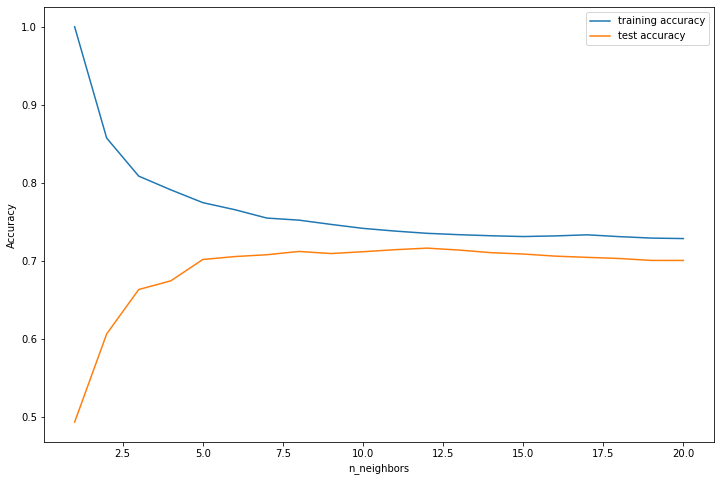

The optimal number of neighbors is 12


In [251]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy = []


# building a visualization of 1 to 50 neighbors
neighbors_settings = range(1, 21)


for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors = n_neighbors)
    clf.fit(X_train_STAND, y_train_STAND)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(X_train_STAND, y_train_STAND))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(X_test_STAND, y_test_STAND))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
plt.plot(neighbors_settings, test_accuracy,     label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()


# finding the optimal number of neighbors
opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1
print(f"""The optimal number of neighbors is {opt_neighbors}""")

In [252]:
knn_stand = KNeighborsRegressor(algorithm = 'auto',
                                n_neighbors = 12)



# FITTING the model based on the training data
knn_stand_fit = knn_stand.fit(X_train_STAND, y_train_STAND)



# PREDITCING on new data
knn_stand_pred = knn_stand_fit.predict(X_test_STAND)



# SCORING the results
print('KNN Training Score:', knn_stand.score(X_train_STAND, y_train_STAND).round(4))
print('KNN Testing Score :',  knn_stand.score(X_test_STAND, y_test_STAND).round(4))


# saving scoring data for future use
knn_stand_score_train = knn_stand.score(X_train_STAND, y_train_STAND).round(4)
knn_stand_score_test  = knn_stand.score(X_test_STAND, y_test_STAND).round(4)


# displaying and saving the gap between training and testing
print('KNN Train-Test Gap:', abs(knn_stand_score_train - knn_stand_score_test).round(4))
knn_stand_test_gap = abs(knn_stand_score_train - knn_stand_score_test).round(4)

KNN Training Score: 0.7353
KNN Testing Score : 0.7163
KNN Train-Test Gap: 0.019


In [253]:
# comparing results

print(f"""
Model          Train Score      Test Score
-----           -----------      ----------
OLS             {lr_train_score}            {lr_test_score}
Lasso           {lasso_train_score}            {lasso_test_score}
ARD*Selected    {ard_train_score}             {ard_test_score}
KNN             {knn_stand_score_train}            {knn_stand_score_test}
""")


# creating a dictionary for model results
model_performance = {
    
    'Model Type'    : ['OLS', 'Lasso', 'ARD* Selected', 'KNN'],
           
    'Training' : [lr_train_score, lasso_train_score, ard_train_score, knn_stand_score_train],
           
    'Testing'  : [lr_test_score, lasso_test_score, ard_test_score, knn_stand_score_test],
                    
    'Train-Test Gap' : [lr_test_gap, lasso_test_gap, ard_test_gap, knn_stand_test_gap],
                    
    'Model Size' : [len(lr_model_lst), len(lasso_model_lst), len(ard_model_lst), 'NA'],
                    
    'Model' : [lr_model_lst, lasso_model_lst, ard_model_lst, 'NA']}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)




Model          Train Score      Test Score
-----           -----------      ----------
OLS             0.7659            0.7628
Lasso           0.7548            0.744
ARD*Selected    0.763             0.7625
KNN             0.7353            0.7163

